# Introduction

This notebook demonstrates how to use a LSTM-based Variational Autocoder to classifiy workloads

0      1970-01-16 22:18:34.846
1      1970-01-16 22:18:35.146
2      1970-01-16 22:18:35.446
3      1970-01-16 22:18:35.746
4      1970-01-16 22:18:36.046
                 ...          
8613   1970-01-16 23:01:45.598
8614   1970-01-16 23:01:45.898
8615   1970-01-16 23:01:46.198
8616   1970-01-16 23:01:46.498
8617   1970-01-16 23:01:46.798
Name: Timestamp [ms], Length: 8618, dtype: datetime64[ns]


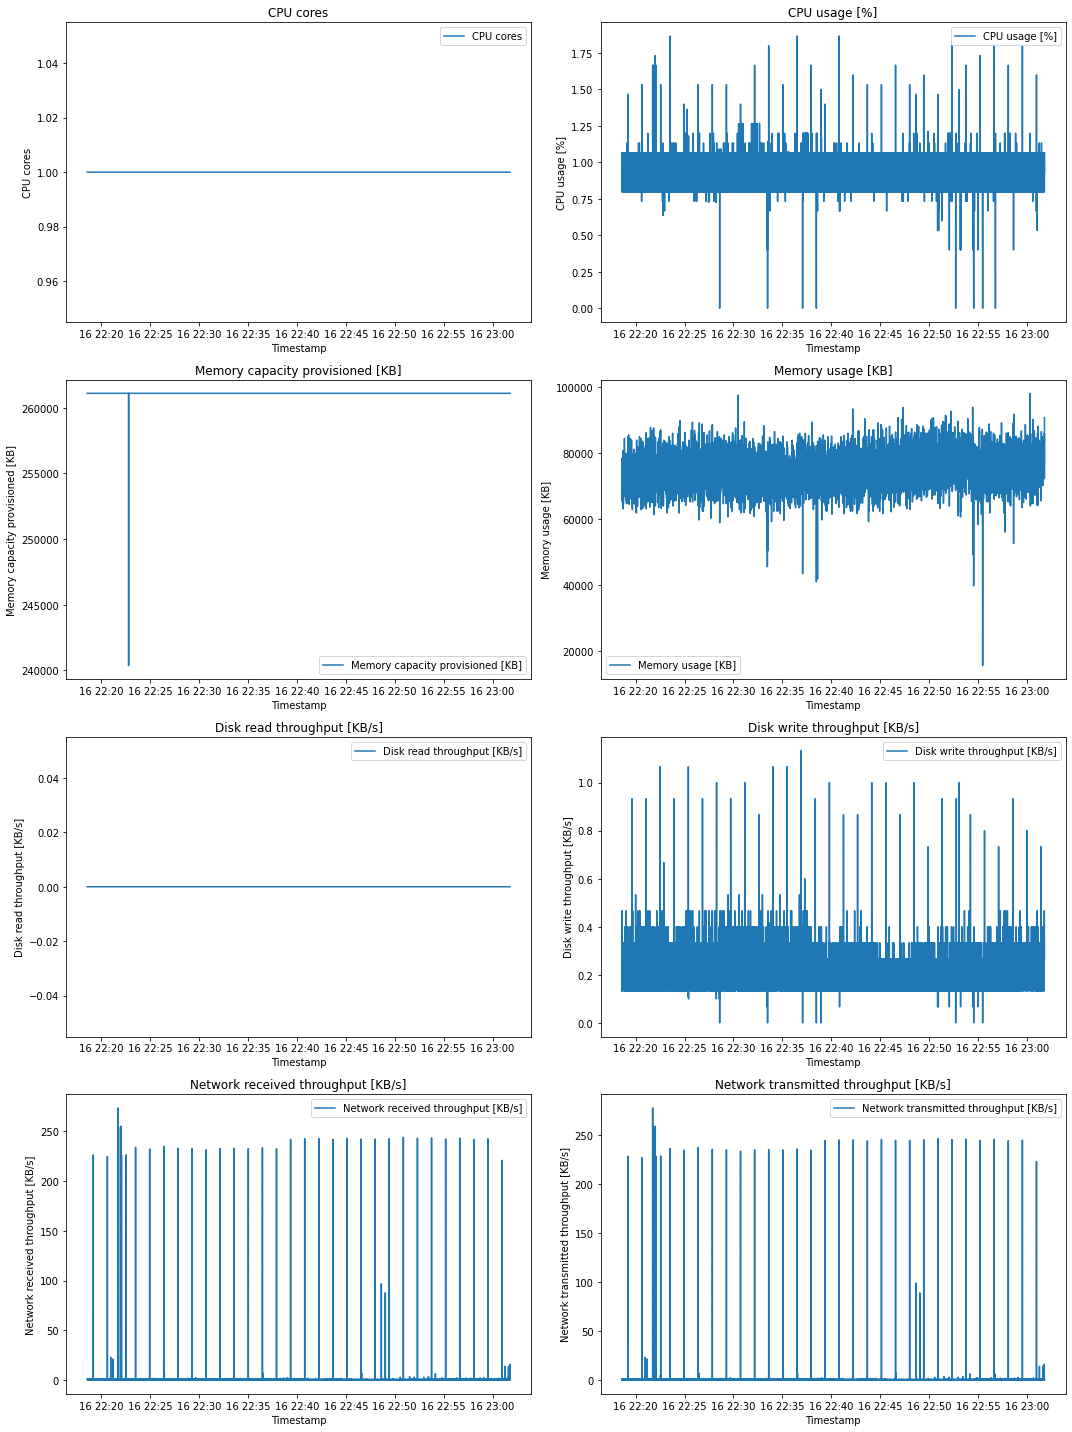

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '../datasets/fastStorage/2013-8/1050.csv'

df = pd.read_csv(file_path, delimiter=';')
df.columns = df.columns.str.strip()
df['Timestamp [ms]'] = pd.to_datetime(df['Timestamp [ms]'], unit='ms')

columns_to_plot = ['CPU cores', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 
                   'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 
                   'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]']

nrows = len(columns_to_plot) // 2 + len(columns_to_plot) % 2
ncols = 2
print(df['Timestamp [ms]'] )
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
for i, column in enumerate(columns_to_plot):
    ax = axs[i // ncols, i % ncols]
    ax.plot(df['Timestamp [ms]'], df[column], label=column)
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(column)
    ax.set_title(column)
    ax.legend()

plt.tight_layout()
plt.show()

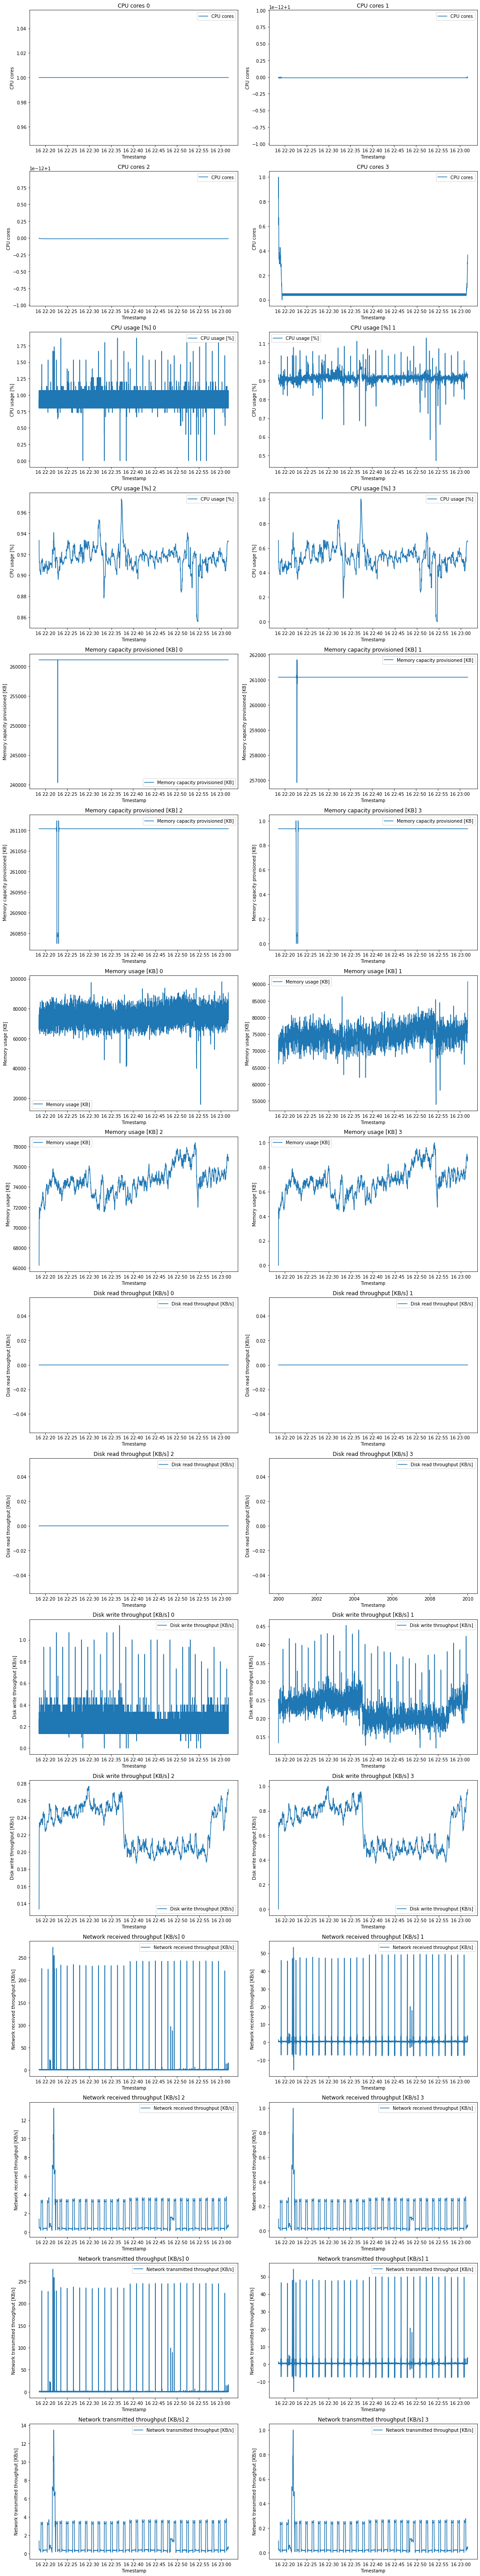

In [5]:

from scipy.signal import butter, filtfilt
import numpy as np
file_path = '../datasets/fastStorage/2013-8/1050.csv'


def lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    if data.shape[0] > order * 3:
        y = filtfilt(b, a, data, axis=0)
    else:
        y = data
    return y

df = pd.read_csv(file_path, delimiter=';')
df.columns = df.columns.str.strip()

df.fillna(0, inplace=True) 

cutoff_frequency = 0.1
sampling_rate = 1
filter_order = 5
window_size = 80
global_max = None
global_min = None

filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
df_filtered = pd.DataFrame(filtered_data, columns=df.columns)

df_moving_average = df_filtered.rolling(window=window_size, min_periods=1).mean()

local_min = df_moving_average.min()
local_max = df_moving_average.max()

if global_min is None or global_max is None:
    global_min = local_min
    global_max = local_max
else:
    global_min = min(global_min, local_min)
    global_max = max(global_max, local_max)
    

filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
df_filtered = pd.DataFrame(filtered_data, columns=df.columns)
df_moving_average = df_filtered.rolling(window=window_size, min_periods=1).mean()

df_normalized = (df_moving_average - global_min) / (global_max - global_min)
df_normalized = np.clip(df_normalized, 0, 1)

df['Timestamp [ms]'] = pd.to_datetime(df['Timestamp [ms]'], unit='ms')
df_normalized['Timestamp [ms]'] = pd.to_datetime(df_moving_average['Timestamp [ms]'], unit='ms')
df_moving_average['Timestamp [ms]'] = pd.to_datetime(df_moving_average['Timestamp [ms]'], unit='ms')
df_filtered['Timestamp [ms]'] = pd.to_datetime(df_filtered['Timestamp [ms]'], unit='ms')

columns_to_plot = ['CPU cores', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 
                   'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 
                   'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]']

plotted_variants = 4

nrows = (len(columns_to_plot) // 2 + len(columns_to_plot) % 2) * plotted_variants
ncols = 2

fig, axs = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
        
for i, column in enumerate(columns_to_plot):
    
    for df_i in range(plotted_variants):
        if df_i == 0:
            df_plot = df
        elif df_i == 1:
            df_plot = df_filtered
        elif df_i == 2:
            df_plot = df_moving_average
        else:
            df_plot = df_normalized
            
        plot_i = df_i + i * plotted_variants
        ax = axs[plot_i // ncols, plot_i % ncols]
        ax.plot(df_plot['Timestamp [ms]'], df_plot[column], label=column)
        ax.set_xlabel('Timestamp')
        ax.set_ylabel(column)
        ax.set_title(column + ' ' + str(df_i))
        ax.legend()

plt.tight_layout()
plt.show()

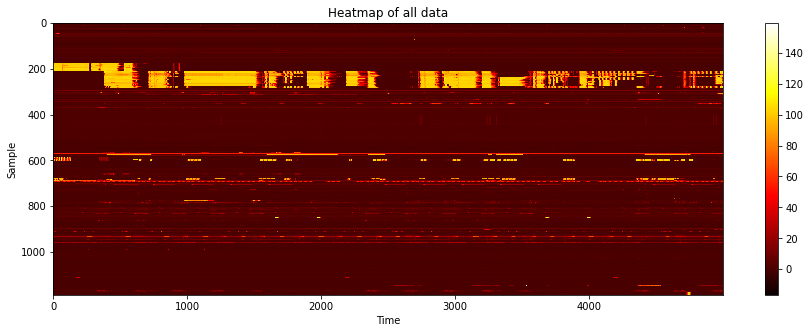

In [6]:
file_paths = ['../datasets/fastStorage/2013-8/{}.csv'.format(i) for i in range(1, 1250)]


def lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    if data.shape[0] > order * 3:
        y = filtfilt(b, a, data, axis=0)
    else:
        y = data
    return y

columns_to_plot = ['CPU cores', 'CPU usage [%]', 'Memory capacity provisioned [KB]', 'Memory usage [KB]', 
                   'Disk read throughput [KB/s]', 'Disk write throughput [KB/s]', 
                   'Network received throughput [KB/s]', 'Network transmitted throughput [KB/s]']

# Load all data
time_steps = 5000
dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, delimiter=';')
    df.columns = df.columns.str.strip()
    filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
    df = pd.DataFrame(filtered_data, columns=df.columns)
    df['Timestamp [ms]'] = pd.to_datetime(df['Timestamp [ms]'], unit='ms')
    
    if (df.shape[0] < time_steps):
            continue
        
    df = df[-time_steps:]
    dfs.append(df)
    
# Print shape of dfs
    
# Plot only 30 random samples in one plot
""" fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for df in dfs[:30]:
    #for column in columns_to_plot:
    ax.plot(df['Timestamp [ms]'], df['CPU usage [%]'], label='CPU usage [%]')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Value')
    ax.set_title('All data')
    ax.legend() """

# Change above plot to a heatmap instead
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
data = np.zeros((len(dfs), time_steps))
for i, df in enumerate(dfs):
    data[i, :] = df['CPU usage [%]'].values
im = ax.imshow(data, aspect='auto', cmap='hot', interpolation='nearest')
ax.set_xlabel('Time')
ax.set_ylabel('Sample')
ax.set_title('Heatmap of all data')
fig.colorbar(im, ax=ax)
plt.show()

## Preprocessing and dataset generation

In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt


def lowpass_filter(data, cutoff, fs, order):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    if data.shape[0] > order * 3:
        y = filtfilt(b, a, data, axis=0)
    else:
        y = data
    return y

def load_data(file_paths, time_steps, cutoff_frequency, sampling_rate, filter_order, window_size):
    data_list = []
    global_min = None
    global_max = None
    min_len = float('inf')

    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter=';')
        df = df[['\tCPU usage [%]', '\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]', '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]']]
        df.fillna(0, inplace=True) 

        filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
        df_filtered = pd.DataFrame(filtered_data, columns=df.columns)

        df_moving_average = df_filtered.rolling(window=window_size, min_periods=1).mean()
        
        if (df_moving_average.shape[0] < time_steps):
            continue
        
        df_moving_average = df_moving_average[-time_steps:]
        #print(df_moving_average.shape, file_path)

        local_min = df_moving_average.min()
        local_max = df_moving_average.max()
        
        #print("local", local_min, local_max)
        
        if global_min is None or global_max is None:
            global_min = local_min
            global_max = local_max
        else:
            # find the global min and max between the dataframes and update the global min and max
            global_min = global_min.combine(local_min, min)
            global_max = global_max.combine(local_max, max)
            #print("global", global_min, global_max)
            

    for file_path in file_paths:
        df = pd.read_csv(file_path, delimiter=';')
        df = df[['\tCPU usage [%]', '\tMemory usage [KB]', '\tDisk read throughput [KB/s]', '\tDisk write throughput [KB/s]', '\tNetwork received throughput [KB/s]', '\tNetwork transmitted throughput [KB/s]']]
        df.fillna(0, inplace=True) 

        filtered_data = lowpass_filter(df.values, cutoff_frequency, sampling_rate, filter_order)
        df_filtered = pd.DataFrame(filtered_data, columns=df.columns)
        df_moving_average = df_filtered.rolling(window=window_size, min_periods=1).mean()

        if (df_moving_average.shape[0] < time_steps):
            continue
        
        df_moving_average = df_moving_average[-time_steps:]

        df_normalized = (df_moving_average - global_min) / (global_max - global_min)
        df_normalized = np.clip(df_normalized, 0, 1)
        
        data_list.append(df_normalized.values[-time_steps:])

    all_data = np.concatenate(data_list, axis=0)
    num_samples = all_data.shape[0] // time_steps
    print(all_data.shape, num_samples, time_steps)
    all_data = all_data[:num_samples * time_steps]
    data_reshaped = all_data.reshape((num_samples, time_steps, -1))
    print(data_reshaped.shape)

    return torch.tensor(data_reshaped, dtype=torch.float32)

num_features = 6
time_steps = 5000
file_paths = ['../datasets/fastStorage/2013-8/{}.csv'.format(i) for i in range(1, 1250)]
cutoff_frequency = 0.1
sampling_rate = 1
filter_order = 5
window_size = 80

data_tensor = load_data(file_paths, time_steps, cutoff_frequency, sampling_rate, filter_order, window_size)
dataset = TensorDataset(data_tensor)
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

print(f"Data tensor shape: {data_tensor.shape}")

(5940000, 6) 1188 5000
(1188, 5000, 6)
Data tensor shape: torch.Size([1188, 5000, 6])


## Plot some examples from the dataset

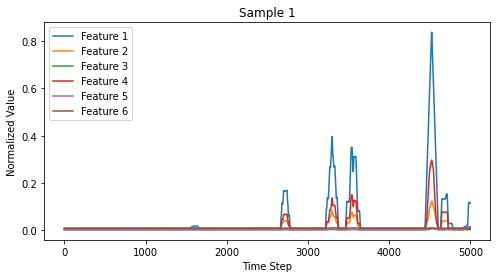

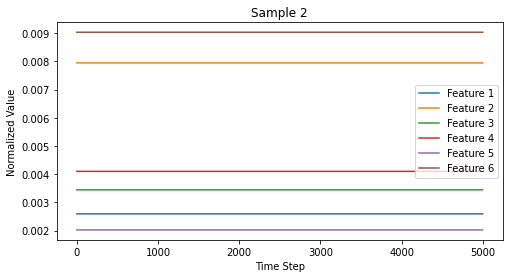

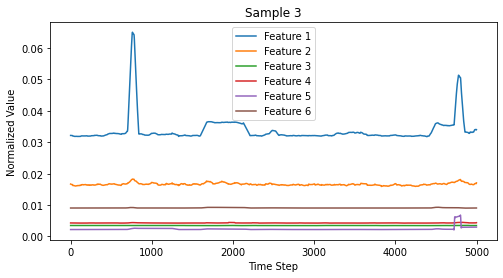

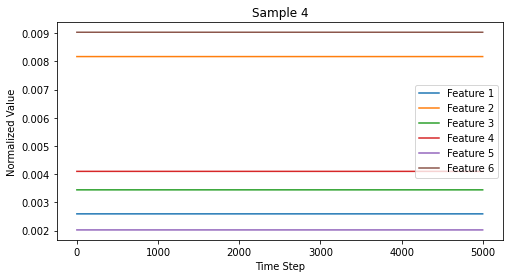

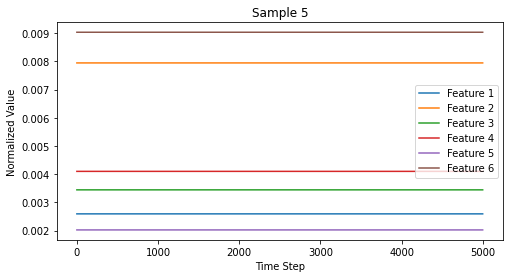

In [9]:
def plot_samples(data_tensor, num_samples_to_plot=5, time_steps=time_steps):
    data_numpy = data_tensor.numpy()

    for sample_index in range(min(num_samples_to_plot, data_tensor.shape[0])):
        plt.figure(figsize=(8, 4))
        for feature_index in range(data_tensor.shape[2]):
            plt.plot(range(time_steps), data_numpy[sample_index, :, feature_index], label=f'Feature {feature_index+1}')
        
        plt.title(f'Sample {sample_index+1}')
        plt.xlabel('Time Step')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.show()

plot_samples(data_tensor, num_samples_to_plot=5, time_steps=time_steps)

## Define and train LSTM-Variational Autoencoder

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class LSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_layers=3):
        super(LSTMEncoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        mu = self.fc_mu(hidden[-1])
        logvar = self.fc_logvar(hidden[-1])
        return mu, logvar

class LSTMDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_layers=3):
        super(LSTMDecoder, self).__init__()
        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, z, seq_length):
        z = z.unsqueeze(1).repeat(1, seq_length, 1)
        output, _ = self.lstm(z)
        output = self.fc(output)
        return output

class LSTMVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, output_dim):
        super(LSTMVAE, self).__init__()
        self.encoder = LSTMEncoder(input_dim, hidden_dim, latent_dim)
        self.decoder = LSTMDecoder(latent_dim, hidden_dim, output_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, seq_length):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, seq_length), mu, logvar

def vae_loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

input_dim = num_features
hidden_dim = 64
latent_dim = 10
output_dim = num_features

model = LSTMVAE(input_dim, hidden_dim, latent_dim, output_dim)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, data_loader, optimizer, num_epochs=40):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, data in enumerate(data_loader):
            data = data[0].to('cuda' if torch.cuda.is_available() else 'cpu')
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data, data.size(1))
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            total_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch}, Average Loss: {total_loss / len(data_loader.dataset)}')

train(model, data_loader, optimizer)

Epoch 0, Average Loss: 234.93823046957203


## Plot some generates samples

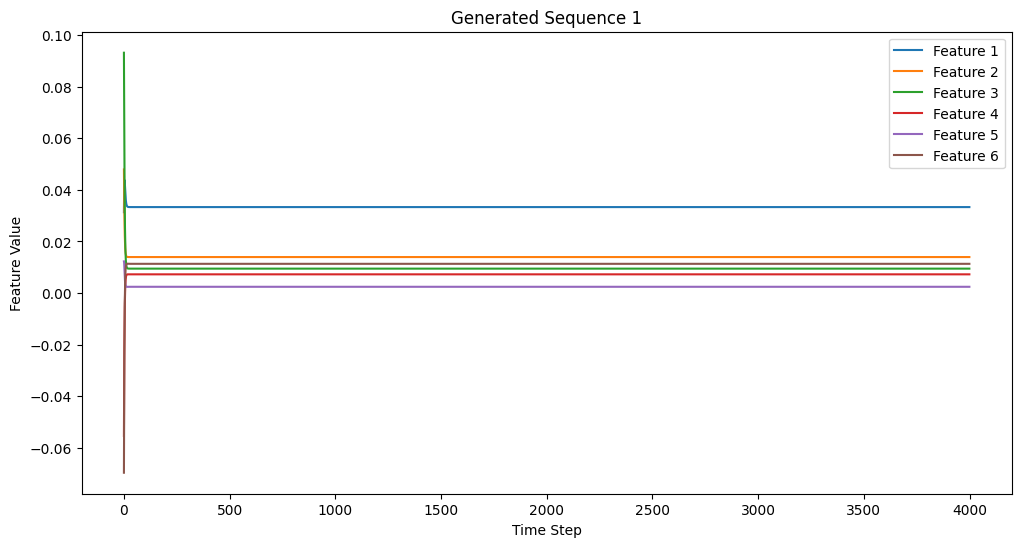

In [6]:
def generate_from_vae(model, num_samples, latent_dim, seq_length):
    model.eval()
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, latent_dim).to('cuda' if torch.cuda.is_available() else 'cpu')
        generated_sequences = model.decoder(latent_samples, seq_length)      
        return generated_sequences.cpu()

num_samples = 5
seq_length = 4000

generated_data = generate_from_vae(model, num_samples, latent_dim, seq_length)

def plot_generated_data(generated_data, num_sequences_to_plot=5):
    num_features = generated_data.shape[2]

    for i in range(min(num_sequences_to_plot, generated_data.shape[0])):
        plt.figure(figsize=(12, 6))
        for feature_index in range(num_features):
            plt.plot(generated_data[i, :, feature_index], label=f'Feature {feature_index + 1}')
        plt.title(f'Generated Sequence {i + 1}')
        plt.xlabel('Time Step')
        plt.ylabel('Feature Value')
        plt.legend()
        plt.show()

plot_generated_data(generated_data, num_sequences_to_plot=1)

## t-SNE Visualization of Latent Space

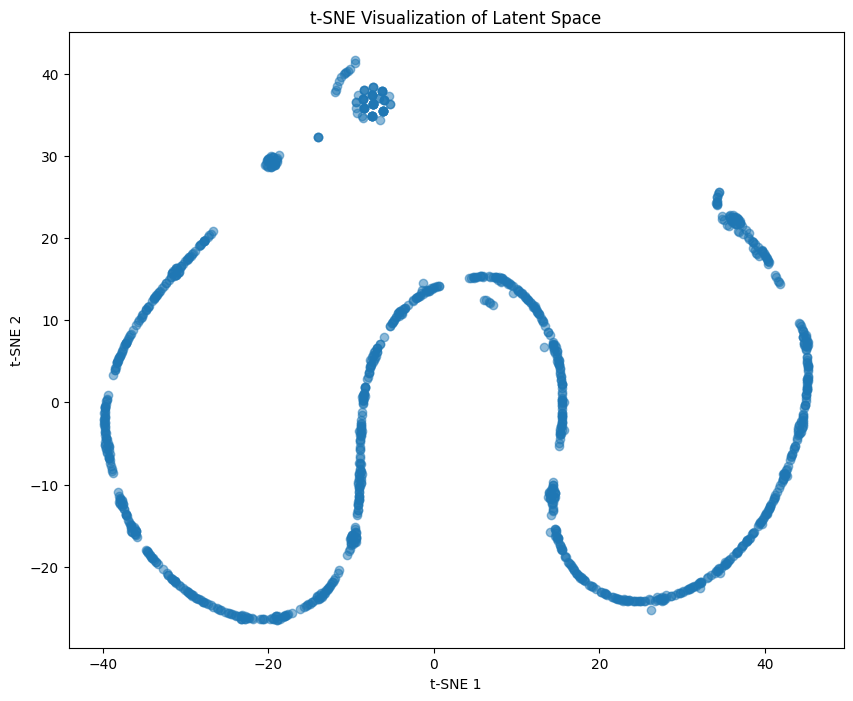

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def extract_latent_variables(model, data_loader):
    model.eval()
    latent_vars = []

    with torch.no_grad():
        for batch in data_loader:
            data = batch[0].to('cuda' if torch.cuda.is_available() else 'cpu')
            mu, _ = model.encoder(data)
            latent_vars.append(mu.cpu().numpy())

    return np.concatenate(latent_vars)

latent_variables = extract_latent_variables(model, data_loader)

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(latent_variables)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

## PCA Visualization of Latent Space

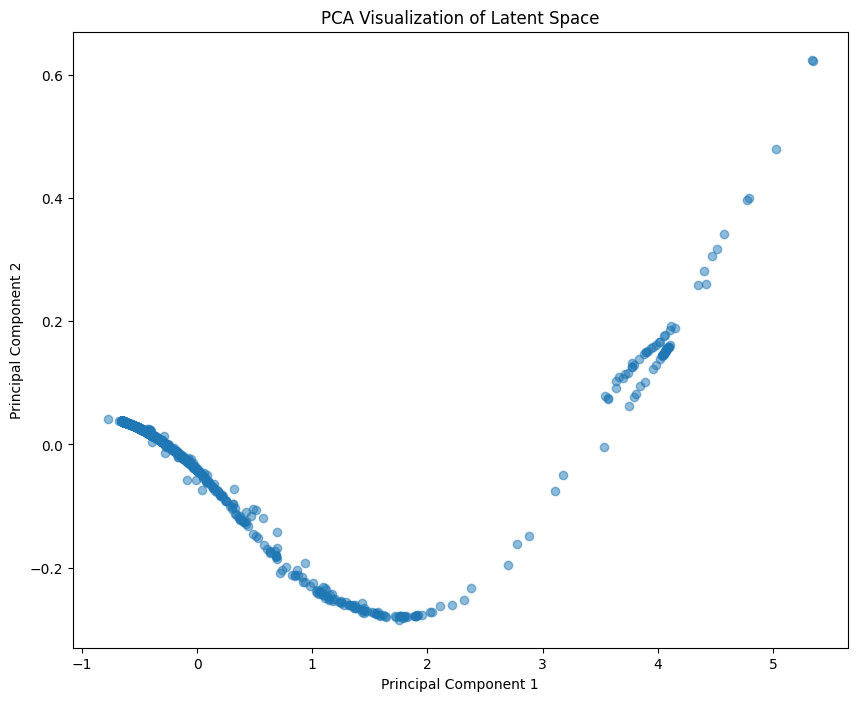

In [8]:
def extract_latent_variables(model, data_loader):
    model.eval()
    latent_vars = []

    with torch.no_grad():
        for batch in data_loader:
            data = batch[0].to('cuda' if torch.cuda.is_available() else 'cpu')
            mu, _ = model.encoder(data)
            latent_vars.append(mu.cpu().numpy())

    return np.concatenate(latent_vars)

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

latent_variables = extract_latent_variables(model, data_loader)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(latent_variables)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA Visualization of Latent Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Use the latent space to compare similarity between two timeseries

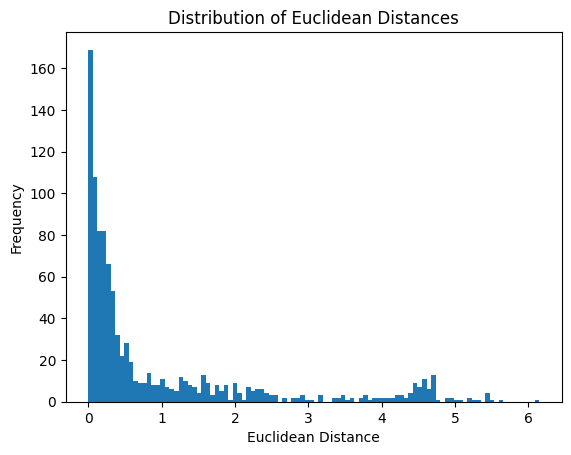

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

distances = []
for i in range(1000):
    idx1, idx2 = np.random.choice(len(data_tensor), 2, replace=False)

    random_sample_1 = data_tensor[idx1]
    random_sample_2 = data_tensor[idx2]

    random_sample_1 = random_sample_1.to(device)
    random_sample_2 = random_sample_2.to(device)

    # Now you can pass the data through the encoder without encountering a device mismatch error
    model.eval()
    with torch.no_grad():
        encoded_1, _ = model.encoder(random_sample_1.unsqueeze(0))
        encoded_2, _ = model.encoder(random_sample_2.unsqueeze(0))

    # After encoding, you can calculate the distance
    euclidean_distance = torch.nn.functional.pairwise_distance(encoded_1, encoded_2)
    distances.append(euclidean_distance.item())

# plot a distribution of the distances
plt.hist(distances, bins=100)
plt.title('Distribution of Euclidean Distances')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.show()

# Print out the distance
#print(f"The euclidean distance between the time series in the latent space is: {avg_dist / 100}")
